# July 4-6,11, 2022: Compute Intersubject Functional Correlation (ISFC) values for `early` and `late` periods in `threat` and `safe` conditions

In [1]:
import os
import sys
from os.path import join as pjoin

import numpy as np
import pandas as pd
import pickle, random
from tqdm import tqdm
from scipy.stats import (norm, zscore, permutation_test)
from itertools import permutations

# ISC
from brainiak.isc import (isc, isfc, bootstrap_isc, compute_summary_statistic, squareform_isfc)
from statsmodels.stats.multitest import multipletests
from scipy.spatial.distance import squareform

# plotting
import matplotlib.pyplot as plt
plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

# main dirs
proj_dir = pjoin(os.environ['HOME'], 'network_dynamics')
results_dir = f"{proj_dir}/results"
month_dir = f"{proj_dir}/nb/jun22"

# folders
sys.path.insert(0, proj_dir)
# import helpers.dataset_utils as dataset_utils

In [2]:
'''
exploratory data
'''
class ARGS(): pass
args = ARGS()

args.SEED = 74
args.LABELS = [0, 1]
args.NAMES = ['safe', 'threat']
args.MASK = -100

args.num_rois = 85
args.roi_idxs = np.arange(args.num_rois)

with open(f"{proj_dir}/data/max/exploratory_data.pkl", 'rb') as f:
    X = pickle.load(f)

In [3]:
'''
find minimum number of trials across subjects
'''
min_trials = []
for label in args.LABELS:
    min_trials += [x.shape[0] for x in X[label]]
min_trials = min(min_trials)

ts = {}
for label, name in zip(args.LABELS, args.NAMES):
    ts[name] = []
    for x in X[label]:
        trl, t, r = x.shape
        x = np.reshape(x[:min_trials, ...], (min_trials*t, r))
        ts[name].append(zscore(x, axis=0))

## Following the pipeline in ISC tutorial
Paper: https://academic.oup.com/scan/article/14/6/667/5489905
Tutorial: https://github.com/snastase/isc-tutorial

Statistical significance was assessed by a nonparametric bootstrap hypothesis test resampling left-out subjects and corrected for multiple tests by controlling FDR at .05.

i.e.:
1. Compute leave-one-out (LOO) ISC and ISFC values
2. Bootstrap hypothesis testing, (Chen et al.2016)
3. Multiple tests correction: False Discovery Rate (FDR) at 0.05.

LOO method relates to computing ISFC values, as the mean time series of the remaining subjects converges to the common signal across subjects.

## `early` and `late` periods 

In [4]:
def get_isfc_significant_rois(args, ts):
    corrs = {}; bootstraps = {}; q = {}; z = {}; rois = {}
    observed_isfcs = {}; observed_p_vals = {}; significant_rois = {}; conf_intervals = {}

    for block in ts.keys():
        isfcs, iscs = isfc(
            ts[block], 
            pairwise=args.pairwise, 
            vectorize_isfcs=args.vectorize_isfcs
        )
        corrs[block] = {'isfcs':isfcs, 'iscs':iscs}

        bootstraps[block] = {}
        q[block] = {}
        z[block] = {}
        rois[block] = {}
        for corr_name in args.CORR_NAMES:
            
            # permutation test
            observed, ci, p, distribution = bootstrap_isc(
                corrs[block][corr_name], 
                pairwise=args.pairwise, 
                ci_percentile=95, 
                summary_statistic='median',
                n_bootstraps=args.n_bootstraps
            )
            bootstraps[block][corr_name] = observed, ci, p, distribution

            # # multiple tests correction
            # q[block][corr_name] = multipletests(bootstraps[block][corr_name][2], method='fdr_by')[1]
            # z[block][corr_name] = np.abs(norm.ppf(q[block][corr_name]))

            # surviving rois
            # rois[block][corr_name] = q[block][corr_name] < 0.05
            rois[block][corr_name] = bootstraps[block][corr_name][2] < 0.05
            print(
                (
                    f"percent of significant roi(-pairs) for " 
                    f"condition {block} and correlation {corr_name[:-1]} = " 
                    f"{100. * np.sum(rois[block][corr_name]) / len(rois[block][corr_name])} %"
                )
            )

        # isfc matrix
        observed_isfcs[block] = squareform_isfc(bootstraps[block]['isfcs'][0], bootstraps[block]['iscs'][0])
        observed_p_vals[block] = squareform_isfc(bootstraps[block]['isfcs'][2], bootstraps[block]['iscs'][2])
        significant_rois[block] = squareform_isfc(rois[block]['isfcs'], rois[block]['iscs'])
        conf_intervals[block] = (
            squareform_isfc(
                bootstraps[block]['isfcs'][1][0],
                bootstraps[block]['iscs'][1][0]
            ),
            squareform_isfc(
                bootstraps[block]['isfcs'][1][1],
                bootstraps[block]['iscs'][1][1]
            )
        ) 
    
    return observed_isfcs, observed_p_vals, significant_rois, conf_intervals, corrs, bootstraps, rois

In [5]:
def plot_isfcs(args, isfcs, rois): 
    vmin, vmax = [], []
    for block in isfcs.keys():
        vmin += [np.min(isfcs[block])]
        vmax += [np.max(isfcs[block])]
    vmin, vmax = min(vmin), max(vmax)

    nrows, ncols = len(args.LABELS), len(args.PERIODS)
    fig, axs = plt.subplots(
        nrows=nrows, 
        ncols=ncols, 
        figsize=(5*ncols, 4*nrows), 
        sharex=False, 
        sharey=False, 
        dpi=120
    )

    plt.subplots_adjust(
        left=None, bottom=None, 
        right=None, top=None, 
        wspace=None, hspace=0.5
    )

    for label, name in zip(args.LABELS, args.NAMES):
        for idx_period, period in enumerate(args.PERIODS):
            ax = axs[label, idx_period]
            block = f"{name}_{period}"

            im = ax.imshow(isfcs[block] * rois[block], cmap='RdBu_r', vmin=vmin, vmax=vmax)
            ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

            ax.set_title(f"{block}")
            ax.set_ylabel(f"rois")
            ax.set_xlabel(f"rois")
    
    return None

## Intersubject correlations

In [6]:
'''
time series of early and late periods
'''
args.PERIODS = ['early', 'late']
# time periods
args.TR = 1.25 #seconds
EARLY = np.arange(2.5, 8.75+args.TR, args.TR) // args.TR
LATE = np.arange(10.0, 16.25+args.TR, args.TR) // args.TR
EARLY = EARLY.astype(int)
LATE = LATE.astype(int)
args.PERIOD_TRS = [EARLY, LATE]

ts = {}
for label, name in zip(args.LABELS, args.NAMES):
    for idx_period, (period, TRs) in enumerate(zip(args.PERIODS, args.PERIOD_TRS)):
        ts[f"{name}_{period}"] = []
        for x in X[label]:
            x = x[:, args.PERIOD_TRS[idx_period], :]
            trl, t, r = x.shape
            x = np.reshape(x[:min_trials, ...], (min_trials*t, r))
            ts[f"{name}_{period}"] += [zscore(x, axis=0)]

percent of significant roi(-pairs) for condition safe_early and correlation isfc = 29.747899159663866 %
percent of significant roi(-pairs) for condition safe_early and correlation isc = 25.88235294117647 %
percent of significant roi(-pairs) for condition safe_late and correlation isfc = 7.42296918767507 %
percent of significant roi(-pairs) for condition safe_late and correlation isc = 5.882352941176471 %
percent of significant roi(-pairs) for condition threat_early and correlation isfc = 32.016806722689076 %
percent of significant roi(-pairs) for condition threat_early and correlation isc = 50.588235294117645 %
percent of significant roi(-pairs) for condition threat_late and correlation isfc = 53.05322128851541 %
percent of significant roi(-pairs) for condition threat_late and correlation isc = 50.588235294117645 %


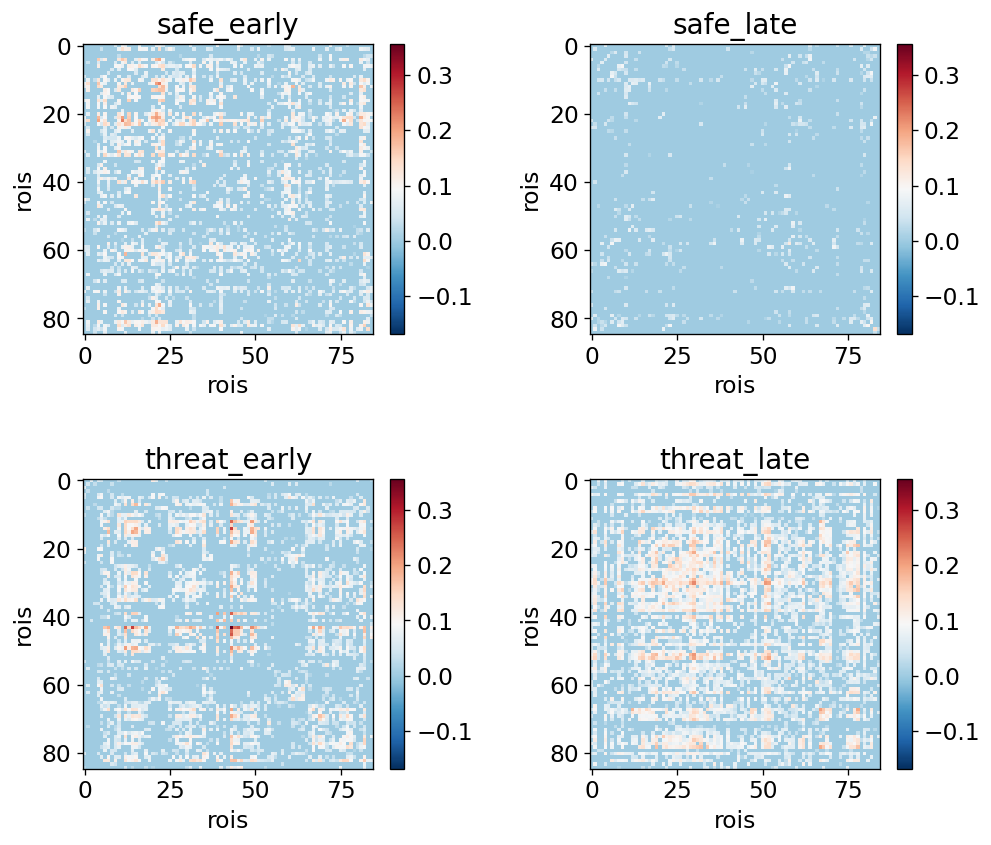

In [7]:
'''
leave-one-out ISFC
bootstrap
FDR correction
'''
args.CORR_NAMES = ['isfcs', 'iscs']
args.pairwise = False
args.vectorize_isfcs = True
args.n_bootstraps = 1000

isfcs, ps, sig_rois, cis, corrs, bootstraps, rois = get_isfc_significant_rois(args, ts)
plot_isfcs(args, isfcs, sig_rois)

Showing ISFC values for each period only for the significant roi-pairs.

## statistical testing: pairwise non parametric permutation test

In [8]:
def statistic(y1, y2, axis):
    return (
        compute_summary_statistic(y1, summary_statistic='median', axis=axis) 
        - compute_summary_statistic(y2, summary_statistic='median', axis=axis)
    ) 

stats_results = {}; diff_isfcs = {}; diff_pvals = {}
for (block1, block2) in tqdm(permutations(corrs.keys(), 2)):
    obs1 = np.concatenate([corrs[block1]['isfcs'], corrs[block1]['iscs']], axis=-1)
    obs2 = np.concatenate([corrs[block2]['isfcs'], corrs[block2]['iscs']], axis=-1)
    
    stats_results[(block1, block2)] = permutation_test(
        data=(obs1, obs2),
        statistic=statistic,
        permutation_type='samples',
        vectorized=True,
        n_resamples=args.n_bootstraps,
        batch=5,
        axis=0,
        random_state=args.SEED
    )

    diff_isfcs[(block1, block2)] = squareform_isfc(
        isfcs=stats_results[(block1, block2)].statistic[:-args.num_rois],
        iscs=stats_results[(block1, block2)].statistic[-args.num_rois:]
    )

    diff_pvals[(block1, block2)] = squareform_isfc(
        isfcs=stats_results[(block1, block2)].pvalue[:-args.num_rois],
        iscs=stats_results[(block1, block2)].pvalue[-args.num_rois:],
    ) < 0.05

    diff_isfcs[(block1, block2)] *= diff_pvals[(block1, block2)]

12it [01:41,  8.43s/it]


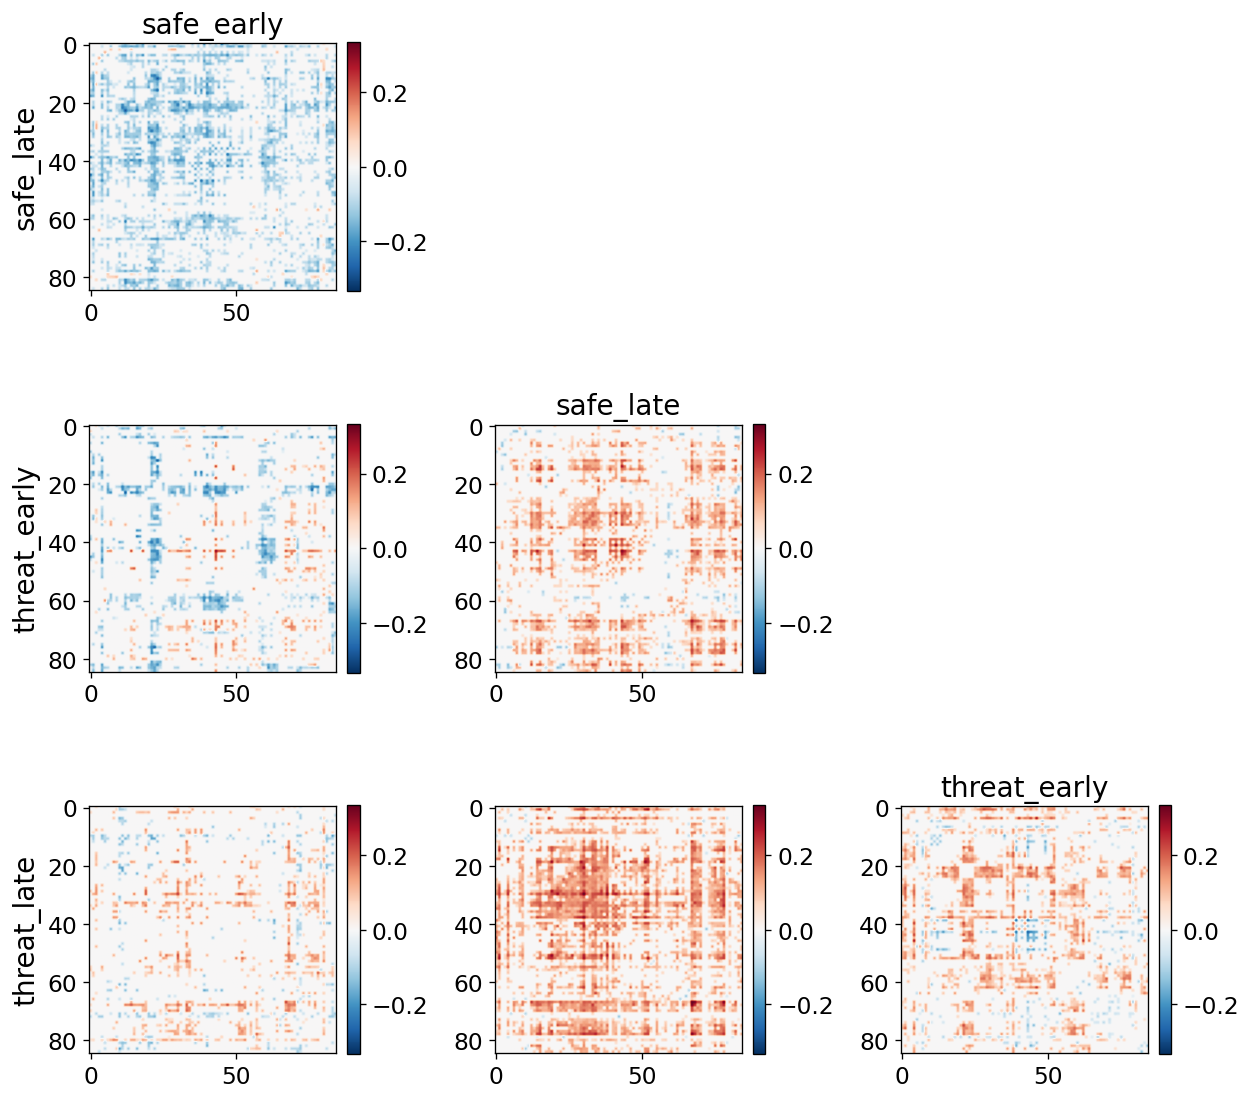

In [44]:
vmin, vmax = [], []
for block in diff_isfcs.keys():
    vmin += [np.min(diff_isfcs[block])]
    vmax += [np.max(diff_isfcs[block])]
vmin, vmax = min(vmin), max(vmax)

nrows, ncols = [len(args.LABELS) * len(args.PERIODS)]*2
fig, axs = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(4*ncols, 4*nrows), 
    sharex=False, 
    sharey=False, 
    dpi=120
)

plt.subplots_adjust(
    left=None, bottom=None, 
    right=None, top=None, 
    wspace=0.5, hspace=0.25
)

blocks = np.stack(list(diff_isfcs.keys()))
for idx_blk1, block1 in enumerate(corrs.keys()):
    for idx_blk2, block2 in enumerate(corrs.keys()):
        if idx_blk1 <= idx_blk2: 
            axs[idx_blk1, idx_blk2].remove()
            continue

        ax = axs[idx_blk1, idx_blk2]

        im = ax.imshow(diff_isfcs[(block1, block2)], cmap='RdBu_r', vmin=vmin, vmax=vmax)
        ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

        if idx_blk1 == idx_blk2+1: ax.set_title(f"{block2}")
        if idx_blk2 == 0: ax.set_ylabel(f"{block1}", size='large')
        # ax.set_xlabel(f"rois")
    